# Monte Carlo Methods

In this notebook, you will write your own implementations of many Monte Carlo (MC) algorithms. 

While we have provided some starter code, you are welcome to erase these hints and write your code from scratch.

### Part 0: Explore BlackjackEnv

We begin by importing the necessary packages.

In [2]:
import sys
import gym
import numpy as np
from collections import defaultdict

from plot_utils import plot_blackjack_values, plot_policy

Use the code cell below to create an instance of the [Blackjack](https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py) environment.

In [3]:
env = gym.make('Blackjack-v0')

Each state is a 3-tuple of:
- the player's current sum $\in \{0, 1, \ldots, 31\}$,
- the dealer's face up card $\in \{1, \ldots, 10\}$, and
- whether or not the player has a usable ace (`no` $=0$, `yes` $=1$).

The agent has two potential actions:

```
    STICK = 0
    HIT = 1
```
Verify this by running the code cell below.

In [4]:
print(env.observation_space)
print(env.action_space)

Tuple(Discrete(32), Discrete(11), Discrete(2))
Discrete(2)


Execute the code cell below to play Blackjack with a random policy.  

(_The code currently plays Blackjack three times - feel free to change this number, or to run the cell multiple times.  The cell is designed for you to get some experience with the output that is returned as the agent interacts with the environment._)

In [5]:
for i_episode in range(3):
    state = env.reset()
    while True:
        action = env.action_space.sample()
        print(f'(St, At) = ({state}, {action})')
        state, reward, done, info = env.step(action)
        print(f'(St+1, R) = ({state}, {reward})')
        if done:
            print('End game! Reward: ', reward)
            print('You won :)\n') if reward > 0 else print('You lost :(\n')
            break

(St, At) = ((19, 4, False), 1)
(St+1, R) = ((24, 4, False), -1.0)
End game! Reward:  -1.0
You lost :(

(St, At) = ((11, 9, False), 1)
(St+1, R) = ((16, 9, False), 0.0)
(St, At) = ((16, 9, False), 1)
(St+1, R) = ((19, 9, False), 0.0)
(St, At) = ((19, 9, False), 0)
(St+1, R) = ((19, 9, False), 0.0)
End game! Reward:  0.0
You lost :(

(St, At) = ((14, 7, True), 1)
(St+1, R) = ((20, 7, True), 0.0)
(St, At) = ((20, 7, True), 0)
(St+1, R) = ((20, 7, True), 1.0)
End game! Reward:  1.0
You won :)



### Part 1: MC Prediction

In this section, you will write your own implementation of MC prediction (for estimating the action-value function).  

We will begin by investigating a policy where the player _almost_ always sticks if the sum of her cards exceeds 18.  In particular, she selects action `STICK` with 80% probability if the sum is greater than 18; and, if the sum is 18 or below, she selects action `HIT` with 80% probability.  The function `generate_episode_from_limit_stochastic` samples an episode using this policy. 

The function accepts as **input**:
- `bj_env`: This is an instance of OpenAI Gym's Blackjack environment.

It returns as **output**:
- `episode`: This is a list of (state, action, reward) tuples (of tuples) and corresponds to $(S_0, A_0, R_1, \ldots, S_{T-1}, A_{T-1}, R_{T})$, where $T$ is the final time step.  In particular, `episode[i]` returns $(S_i, A_i, R_{i+1})$, and `episode[i][0]`, `episode[i][1]`, and `episode[i][2]` return $S_i$, $A_i$, and $R_{i+1}$, respectively.

In [6]:
# Note: Following the policy of 80% choosing At=stick with pi(At=stick|St) = 0.8, 0.2 otherwise
def generate_episode_from_limit_stochastic(bj_env):
    episode = []
    state = bj_env.reset()
    while True:
        probs = [0.8, 0.2] if state[0] > 18 else [0.2, 0.8]
        action = np.random.choice(np.arange(2), p=probs)
        
        next_state, reward, done, info = bj_env.step(action)
        
        episode.append((state, action, reward))
        state = next_state
        
        if done:
            break
    return episode

Execute the code cell below to play Blackjack with the policy. 

(*The code currently plays Blackjack three times - feel free to change this number, or to run the cell multiple times.  The cell is designed for you to gain some familiarity with the output of the `generate_episode_from_limit_stochastic` function.*)

In [7]:
for i in range(10):
    print(str(i + 1) + ': ', generate_episode_from_limit_stochastic(env))

1:  [((16, 10, True), 1, 0.0), ((19, 10, True), 1, 0.0), ((16, 10, False), 1, -1.0)]
2:  [((13, 7, False), 1, -1.0)]
3:  [((11, 7, False), 1, 0.0), ((21, 7, False), 0, 1.0)]
4:  [((6, 6, False), 1, 0.0), ((14, 6, False), 1, 0.0), ((17, 6, False), 1, -1.0)]
5:  [((7, 7, False), 1, 0.0), ((17, 7, False), 1, -1.0)]
6:  [((12, 10, False), 1, -1.0)]
7:  [((13, 10, False), 1, 0.0), ((14, 10, False), 1, 0.0), ((16, 10, False), 1, -1.0)]
8:  [((8, 9, False), 1, 0.0), ((19, 9, True), 0, 0.0)]
9:  [((12, 9, True), 1, 0.0), ((12, 9, False), 0, 1.0)]
10:  [((11, 10, False), 1, 0.0), ((21, 10, False), 0, 1.0)]


Now, you are ready to write your own implementation of MC prediction.  Feel free to implement either first-visit or every-visit MC prediction; in the case of the Blackjack environment, the techniques are equivalent.

Your algorithm has three arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `generate_episode`: This is a function that returns an episode of interaction.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

In [8]:
np.seterr(divide='ignore', invalid='ignore')

def add_rewards(t):
    return t[-1]

def mc_prediction_q(env, num_episodes, generate_episode, gamma=1.0):
    # Note: Initialize empty dictionaries of arrays of shape n
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    N = defaultdict(lambda: np.zeros(env.action_space.n))
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # loop over episodes
    for i_episode in range(1, num_episodes + 1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
        episode = generate_episode(env)
        visited = []
        for j in range(0, len(episode)):
            # episode[j] = ((18, 7, False), 1, 0.0)
            s, a, r  = episode[j]
            # Is it the first time we visit this St=s
            if s not in visited:
                visited.append(s)
                
                N[s][a] += 1.0
                
                d = 0
                for jj in range(j, len(episode)):
                    reward = episode[j][-1]
                    returns_sum[s][a] += (gamma**d) * reward
                    d += 1
                Q[s][a] += returns_sum[s][a]
                
    # Compute averages for each action in each state
    for s, _ in Q.items():
        for a in range(Q[s].shape[0]):
            if N[s][a] > 0:
                Q[s][a] = Q[s][a] / N[s][a]
    return Q

In [9]:
def mc_prediction_q_v2(env, num_episodes, generate_episode, gamma=1.0):
    # Note: Initialize empty dictionaries of arrays of shape n
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    
    N = defaultdict(lambda: np.zeros(env.action_space.n))
    Q = defaultdict(lambda: np.zeros(env.action_space.n).astype(np.float32))
    
    for i in range(1, num_episodes + 1):
        episode = generate_episode(env)
        
        # Get all the states, actions, rewards
        states, actions, rewards = zip(*episode)
        for t in range(0, len(states)):
            s = states[t]; a = actions[t]
            # First-visit (check passed states to see if current state has been gone through)
            if s not in states[: t]:
                # Compute cummulative rewards from St and on
                # Gt = Rt+1 + jRt+2 + j**2Rt+3 + ... + j**k-1Rt+k
                returns_sum[s][a] += sum([ (gamma**j) * rewards[idx] for j, idx in enumerate(range(t, len(rewards))) ])
                N[s][a] += 1.0
                Q[s][a] = returns_sum[s][a] / N[s][a]
    return Q

_DEBUG_ = False
if _DEBUG_:
    nepisodes = 1
    Q = mc_prediction_q_v2(env, nepisodes, generate_episode_from_limit_stochastic)

Use the cell below to obtain the action-value function estimate $Q$.  We have also plotted the corresponding state-value function.

To check the accuracy of your implementation, compare the plot below to the corresponding plot in the solutions notebook **Monte_Carlo_Solution.ipynb**.

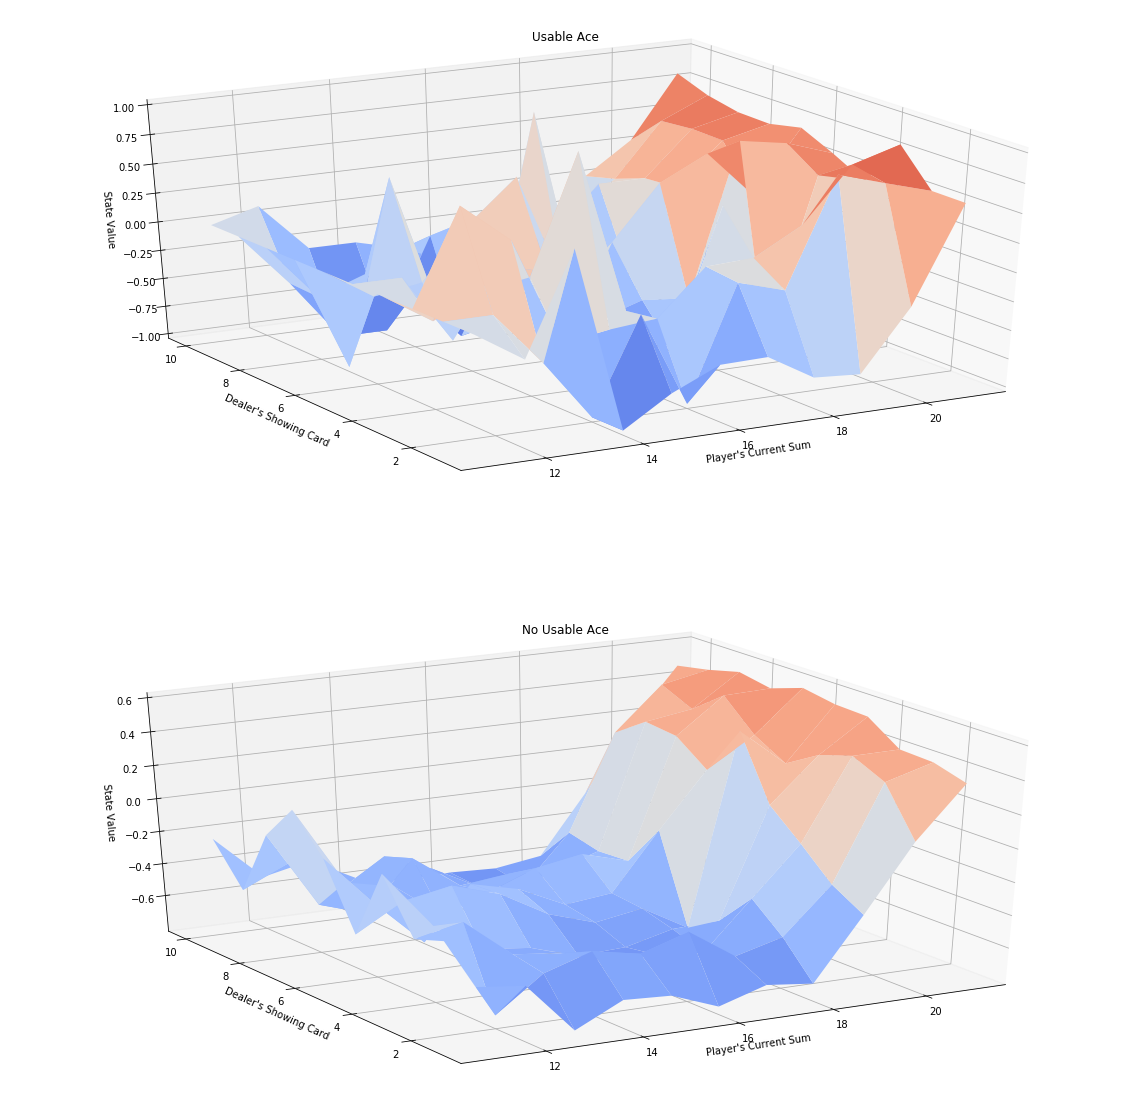

In [10]:
# obtain the action-value function
nepisodes = 5000
Q = mc_prediction_q_v2(env, nepisodes, generate_episode_from_limit_stochastic)

# obtain the corresponding state-value function
V_to_plot = dict((k, (k[0] > 18) * (np.dot([0.8, 0.2], v)) + (k[0] <= 18) * (np.dot([0.2, 0.8], v))) \
         for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V_to_plot)

### Part 2: MC Control

In this section, you will write your own implementation of constant-$\alpha$ MC control.  

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.
- `policy`: This is a dictionary where `policy[s]` returns the action that the agent chooses after observing state `s`.

(_Feel free to define additional functions to help you to organize your code._)

In [115]:
def generate_episode(env, nA, policy):
    if env is None:
        raise('Environment has not been initialized!')
    # init the env
    episode = []
    state = env.reset()
    
    is_terminal = False
    while not is_terminal:
        # sample for action (use the updated policy if we have such state in there)
        # 0 or 1, based on p(a|s)
        action = None
        if state not in policy:
            action = env.action_space.sample()
        else:
            # Pick action with eps-soft policy
            action = np.random.choice(np.arange(nA), p=policy[state])
        
        next_state, reward, done, info = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        
        if done:
            is_terminal = True
            
    return episode

def mc_control(env, num_episodes, alpha, gamma=1.0):
    nA = env.action_space.n
    
    # Policy: state -> (p_a1, p_a2) -> max(p_a1, p_a2)
    policy = defaultdict(lambda: np.ones(nA))
    Q = defaultdict(lambda: np.zeros(nA))
    
    eps = 0.9 # At the start, we want to explore a little more
    
    for i_episode in range(1, num_episodes + 1):
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        eps /= i_episode
        episode = generate_episode(env, nA, policy)
        
        T = len(episode)
        states, actions, rewards = zip(*episode)
        
        for t in range(0, T):
            s = states[t]; a = actions[t]
            
            if s not in states[: t]:
                Gt = sum([ (gamma**d) * rewards[idx] for d, idx in enumerate(range(t, T)) ])
                
                Q[s][a] += alpha * (Gt - Q[s][a])

                # Update the policy: Pick the most likely action of currently estimated state-action value function for the current policy
                a_max = np.argmax(Q[s])

                # Check if the currently picked action is the most likely and update the policy pair
                policy[s] = np.ones(nA) * (eps / nA)
                policy[s][a_max] = ((1 - eps) + (eps / nA))
        
    return policy, Q

Use the cell below to obtain the estimated optimal policy and action-value function.  Note that you should fill in your own values for the `num_episodes` and `alpha` parameters.

In [116]:
# obtain the estimated optimal policy and action-value function
num_episodes = 50000

# At the start, we rely more on the new return, gradually decaying to alpha = 0.1
alpha = 0.02

policy, Q = mc_control(env, num_episodes, alpha)

Episode 50000/50000.

Next, we plot the corresponding state-value function.

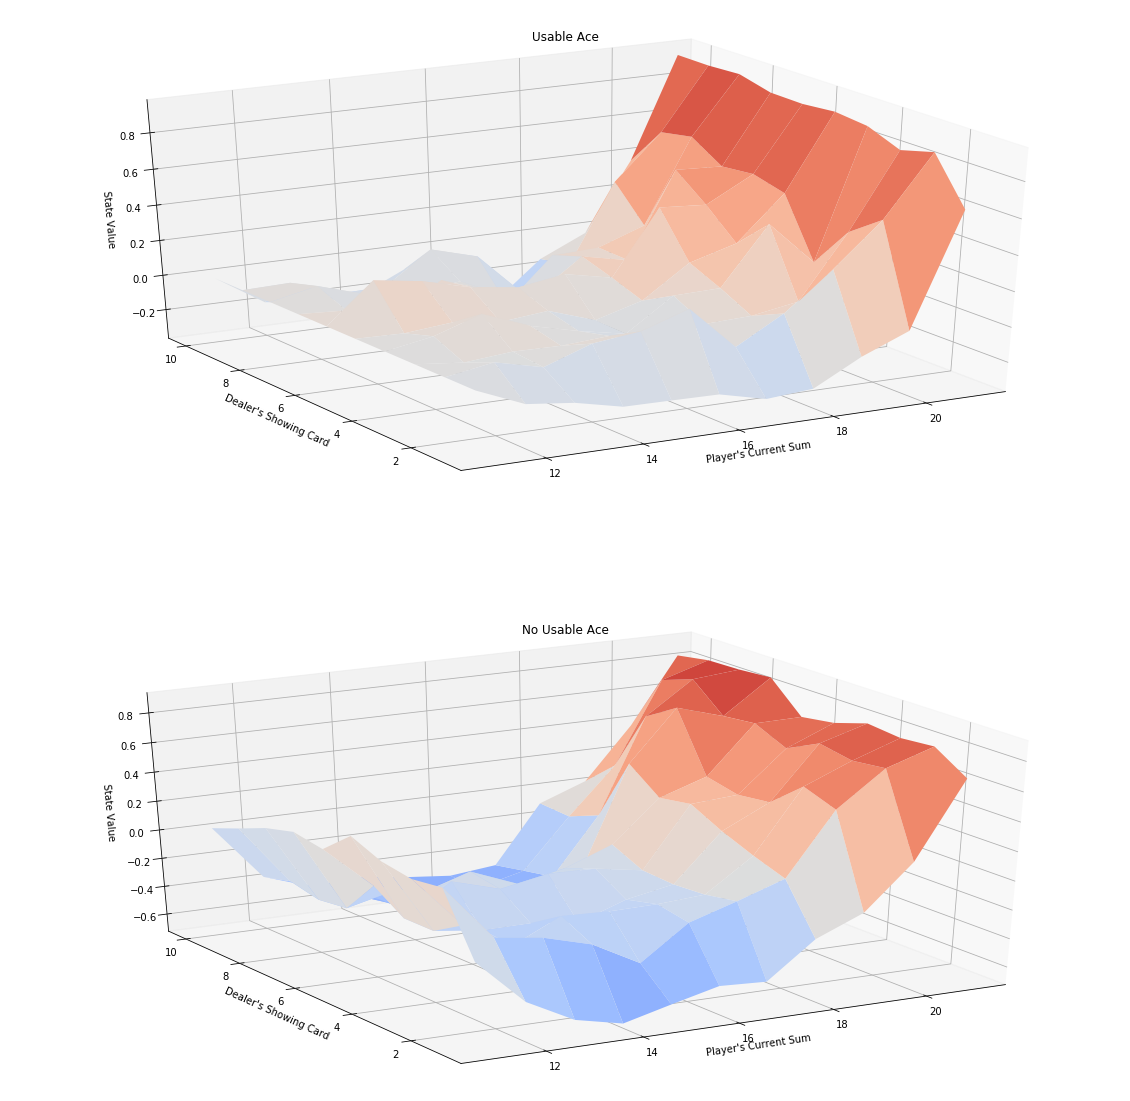

In [117]:
# obtain the corresponding state-value function
V = dict((k,np.max(v)) for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V)

Finally, we visualize the policy that is estimated to be optimal.

In [14]:
# plot the policy
#plot_policy(policy)

The **true** optimal policy $\pi_*$ can be found in Figure 5.2 of the [textbook](http://go.udacity.com/rl-textbook) (and appears below).  Compare your final estimate to the optimal policy - how close are you able to get?  If you are not happy with the performance of your algorithm, take the time to tweak the decay rate of $\epsilon$, change the value of $\alpha$, and/or run the algorithm for more episodes to attain better results.

![True Optimal Policy](images/optimal.png)